## Sweeps purely due to effect of segregation distortion

If sex ratios are distorted, a mutant with an offspring sex ratio that is less distorted or distorted in the other direction will be under positive selection. A mutant with a less distorted offspring ratio will sweep through. Below we assume only one allele in the population responsible for the sex ratio, rb, and a mutant alle with a different sex ratio.

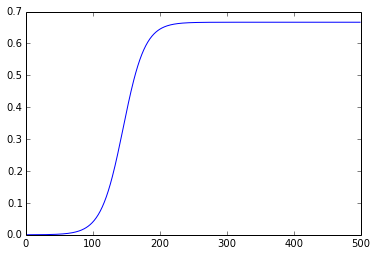

In [55]:
rb = 0.6 # frequency of females for allele in population
rm = 0.45 # frequency of females for mutant allele

def Pm(i): return rm * (frq(i) * (1-rm) + (1-frq(i)) * (1-rb))  +  (1-rm) * (frq(i) * rm + (1-frq(i)) * rb)

def Pb(i): return rb * (frq(i) * (1-rm) + (1-frq(i)) * (1-rb))  +  (1-rb) * (frq(i) * rm + (1-frq(i)) * rb)

cache = dict()

def frq(i):
    if i in cache:
        return cache[i]
    else:
        if i == 0:
            r = 1/10000.0
        else:
            r = frq(i-1) * Pm(i-1) / Pb(i-1)
        cache[i] = r
        return r
n = 500
N = 10000.0 # population size

plot(range(n), map(frq, range(n)))
show()

## Sweep from meiotic drive - quick deterministic calculation only addressing males

This only models the process in males and does not take into account the x alleles caried by females. We model the evolution of system, assumming two variants of both X and Y with interference between them determining the offspring sex, with the following difference equation:

In [56]:
def evolve_next_generation(state):
    x1, x2, y1, y2 = state
    
    f_x1 = x1/(x1+x2)
    f_x2 = x2/(x1+x2)
    f_y1 = y1/(y1+y2)
    f_y2 = y2/(y1+y2)
    
    x1_y1_to_y1 = 0.5
    x2_y1_to_y1 = 0.46
    x1_y2_to_y2 = 0.5
    x2_y2_to_y2 = 0.5
    
    x1_y1_to_x1 = 1.0 - x1_y1_to_y1
    x2_y1_to_x2 = 1.0 - x2_y1_to_y1
    x1_y2_to_x1 = 1.0 - x1_y2_to_y2
    x2_y2_to_x2 = 1.0 - x2_y2_to_y2
    
    next_f_x1 = f_x1 * (f_y1 * x1_y1_to_x1 + f_y2 * x1_y2_to_x1)
    next_f_x2 = f_x2 * (f_y1 * x2_y1_to_x2 + f_y2 * x2_y2_to_x2)
    next_f_y1 = f_y1 * (f_x1 * x1_y1_to_y1 + f_x2 * x2_y1_to_y1)
    next_f_y2 = f_y2 * (f_x1 * x1_y2_to_y2 + f_x2 * x2_y2_to_y2)
    
    return next_f_x1, next_f_x2, next_f_y1, next_f_y2

This assumes that a pairing of x2 with y1 produces slightly more X chromosomes than Y chromosomes while all other pairings produce an X or Y chromosome at random.

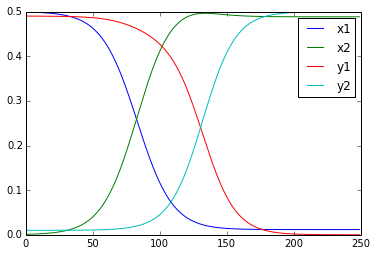

In [57]:
import numpy
no_gen = 250
dynamic_system = numpy.empty( (4, no_gen) )
dynamic_system[:,0] = (0.499, 0.001, 0.49, 0.01)
for i in range(1,no_gen):
    dynamic_system[:,i] = evolve_next_generation(dynamic_system[:,i-1])
    
from pylab import *
plot(dynamic_system[0,], label='x1')
plot(dynamic_system[1,], label='x2')
plot(dynamic_system[2,], label='y1')
plot(dynamic_system[3,], label='y2')
legend()

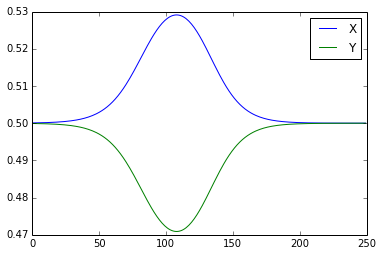

In [58]:
plot(dynamic_system[0,] + dynamic_system[1,], label='X')
plot(dynamic_system[2,] + dynamic_system[3,], label='Y')
legend()

## Sampling of frequency trajectories

This models frequencies in both sexes. We assume that the population has one allele, x1, at the x locus and two, y1 and y2 at the y locus. Males with x1 and either y1 and y2 passes on x and y in equal proportions. A mutant, x2, is introduced that makes males predominantly pass on x gametes if they also carry 1y (i.e. no meitic drive in x2y2 males). x2 will rise in frequency (along with y2) but the sweep stops when y1 is lost from the population.

In [59]:
import numpy
from numpy.random import binomial, multinomial

def relprob(l): return [float(x)/sum(l) for x in l]

def sample_next_generation(state, N, skew):
    x1, x2, y1, y2 = state
    
    # sample N males
    x1y1, x1y2, x2y1, x2y2 = multinomial(N, relprob([x1*y1, x1*y2, x2*y1, x2*y2]))
    
    # sample N females
    x1x1, x1x2, x2x1, x2x2 = multinomial(N, relprob([x1*x1, x1*x2, x2*x1, x2*x2]))
    
    # sample one gamete from each individual to new gamete pool
    x1y1_x1, x1y1_y1 = multinomial(x1y1, [0.5, 0.5])
    x2y1_x2, x2y1_y1 = multinomial(x2y1, [0.5+skew, 0.5-skew])
    x1y2_x1, x1y2_y2 = multinomial(x1y2, [0.5, 0.5])
    x2y2_x2, x2y2_y2 = multinomial(x2y2, [0.5, 0.5])

    x1x1_x1          = x1x1
    x2x1_x2, x2x1_x1 = multinomial(x2x1, [0.5, 0.5])
    x1x2_x1, x1x2_x2 = multinomial(x1x2, [0.5, 0.5])
    x2x2_x2          = x2x2
    
    next_x1 = (x1y1_x1 + x1y2_x1 + x1x1_x1 + x2x1_x1 + x1x2_x1) / (2.*N)
    next_x2 = (x2y1_x2 + x2y2_x2 + x2x1_x2 + x1x2_x2 + x2x2_x2) / (2.*N)
    next_y1 = (x1y1_y1 + x2y1_y1) / (2.*N)
    next_y2 = (x1y2_y2 + x2y2_y2) / (2.*N)
    
    return next_x1, next_x2, next_y1, next_y2

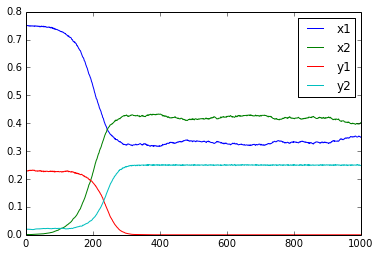

In [60]:
import numpy
no_gen = 1000
N = 100000
skew = 0.05

dynamic_system = numpy.empty( (4, no_gen) )
dynamic_system[:,0] = (0.749, 0.001, 0.23, 0.02)
for i in range(1,no_gen):
    dynamic_system[:,i] = sample_next_generation(dynamic_system[:,i-1], N, skew)
    
from pylab import *
plot(dynamic_system[0,], label='x1')
plot(dynamic_system[1,], label='x2')
plot(dynamic_system[2,], label='y1')
plot(dynamic_system[3,], label='y2')
legend()

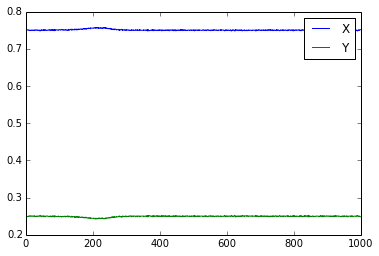

In [61]:
plot(dynamic_system[0,] + dynamic_system[1,], label='X')
plot(dynamic_system[2,] + dynamic_system[3,], label='Y')
legend()

## Sampling frequency trajectories - following sexes separately

In producing genotype frequencies above we ignored the origin of x alleles. Below we follow the contribution to allele frequencies from each sex separately. This seems to produce a slightly stronger effect - but still with the sweep truncated at the loss of y1 from teh population.

In [62]:
import numpy
#from numpy.random import binomial, multinomial
from random import choice, randint

def relprob(l): return [float(x)/sum(l) for x in l]

def sample_next_generation2(state, N, x_skew, y_skew, both_y, both_x):
    x1y1, x1y2, x2y1, x2y2, x1x1, x1x2, x2x1, x2x2 = state
    
    # sample one gamete from each individual to new gamete pool
    x1y1_x1, x1y1_y1 = multinomial(x1y1, [0.5-(y_skew*both_x), 0.5+(y_skew*both_x)])
    x2y1_x2, x2y1_y1 = multinomial(x2y1, [0.5+x_skew, 0.5-x_skew])
    x1y2_x1, x1y2_y2 = multinomial(x1y2, [0.5-y_skew, 0.5+y_skew])
    x2y2_x2, x2y2_y2 = multinomial(x2y2, [0.5+(x_skew*both_y), 0.5+(x_skew*both_y)])

    x1x1_x1          = x1x1
    x2x1_x2, x2x1_x1 = multinomial(x2x1, [0.5, 0.5])
    x1x2_x1, x1x2_x2 = multinomial(x1x2, [0.5, 0.5])
    x2x2_x2          = x2x2
    
    male_x1 = (x1y1_x1 + x1y2_x1) / (2.*N)
    male_x2 = (x2y1_x2 + x2y2_x2) / (2.*N)
    male_y1 = (x1y1_y1 + x2y1_y1) / (2.*N)
    male_y2 = (x1y2_y2 + x2y2_y2) / (2.*N)
    female_x1 = (x1x1_x1 + x2x1_x1 + x1x2_x1) / (2.*N)
    female_x2 = (x2x2_x2 + x2x1_x2 + x1x2_x2) / (2.*N)
    
    # sample N males
    #x1y1, x1y2, x2y1, x2y2 = multinomial(N, relprob([female_x1*male_y1, female_x1*male_y2, female_x2*male_y1, female_x2*male_y2]))
    # sample N females
    #x1x1, x1x2, x2x1, x2x2 = multinomial(N, relprob([female_x1*male_x1, female_x1*male_x2, female_x2*male_x1, female_x2*male_x2]))

    x1y1, x1y2, x2y1, x2y2, \
    x1x1, x1x2, x2x1, x2x2 = multinomial(2*N, relprob([female_x1*male_y1, female_x1*male_y2, female_x2*male_y1, female_x2*male_y2, 
                                                       female_x1*male_x1, female_x1*male_x2, female_x2*male_x1, female_x2*male_x2]))
    
    return x1y1, x1y2, x2y1, x2y2, x1x1, x1x2, x2x1, x2x2


<function sample_next_generation2 at 0x1084a9a28>
[49950, 0, 50, 0, 49900, 50, 50, 0] 100000


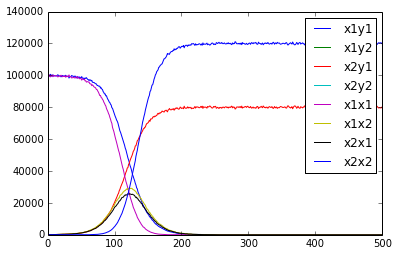

In [63]:
import numpy

no_gen = 500
N = 100000
x_skew = 0.1
y_skew = 0
skew_with_both_y = 1
skew_with_both_x = 1

print sample_next_generation2
x1, x2, y1, y2 = 0.999, 0.001, 1.0, 0.0

genotype_counts = [int(round(0.5 * N * p,  0)) for p in [x1*y1, x1*y2, x2*y1, x2*y2, x1*x1, x1*x2, x2*x1, x2*x2]]
print genotype_counts, sum(genotype_counts)

dynamic_system = numpy.empty( (8, no_gen) )
dynamic_system[:,0] = genotype_counts
for i in range(1,no_gen):
    dynamic_system[:,i] = sample_next_generation2(dynamic_system[:,i-1], N, x_skew,  y_skew, skew_with_both_y, skew_with_both_x)
    
from pylab import *
plot(dynamic_system[0,], label='x1y1')
plot(dynamic_system[1,], label='x1y2')
plot(dynamic_system[2,], label='x2y1')
plot(dynamic_system[3,], label='x2y2')
plot(dynamic_system[4,], label='x1x1')
plot(dynamic_system[5,], label='x1x2')
plot(dynamic_system[6,], label='x2x1')
plot(dynamic_system[7,], label='x2x2')
legend()

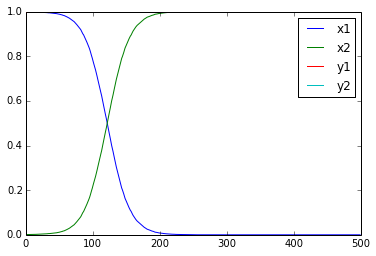

In [64]:
plot(sum(dynamic_system[x,] for x in (0, 1, 4, 4, 5, 6))/sum(dynamic_system[x,] for x in (0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7)), label='x1')
plot(sum(dynamic_system[x,] for x in (2, 3, 5, 6, 7, 7))/sum(dynamic_system[x,] for x in (0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7)), label='x2')
plot(sum(dynamic_system[x,] for x in (0, 2))/sum(dynamic_system[x,] for x in (0, 1, 2, 3)), label='y1')
plot(sum(dynamic_system[x,] for x in (1, 3))/sum(dynamic_system[x,] for x in (0, 1, 2, 3)), label='y2')
legend()

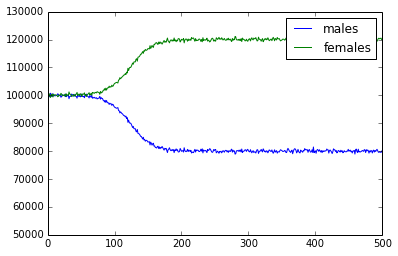

In [65]:
plot(sum(dynamic_system[x,] for x in range(4)), label='males')
plot(sum(dynamic_system[x,] for x in range(4,8)), label='females')
legend()

So - meiotic drive at the at the x (with both y alleles) will prouce a stable sex-ratio distortion. Then what happens if there is a mutant on y that produces the opposite distortion? or if the starting sex-ratio of the before meiotic drive is not 1/2?

A y mutant that counters the meiotic drive of x (is immune and removes the effect of the x) will have the benefit of the sex distortion and sweep through...

In [66]:
import random

def random_weigthed_index(l):
    r = random.random()
    s = float(sum(l))
    i = 0
    c = 0
    while r > c:
        c += l[i]/s
        i += 1
    return i-1

#print random_weigthed_index([1, 2, 3, 4])

def sample_next_generation3(genotypes, N, x_skew, y_skew, both_y, both_x):

    #assert round(sum(genotypes), 0) == round(N, 0), (N, sum(genotypes))

    # sample N males and N females with replacement
    offspring_genotypes = [0] * 8
    
#    m = numpy.random.multinomial(sum(genotypes), [float(x)/sum(genotypes[:4]) for x in genotypes[:4]])
#    male_sample = [item for sublist in [[i]*m[i] for i in range(4)] for item in sublist]
#    random.shuffle(male_sample)
#    f = numpy.random.multinomial(sum(genotypes), [float(x)/sum(genotypes[4:]) for x in genotypes[4:]])
#    female_sample = [item for sublist in [[i]*f[i] for i in range(4)] for item in sublist]
#    random.shuffle(female_sample)

    
#    for male_genotype_idx, female_genotype_idx in zip(male_sample, female_sample):
    for i in range(int(sum(genotypes))):
        # sample pairs of individuals
        male_genotype_idx = random_weigthed_index(genotypes[:4])
        female_genotype_idx = random_weigthed_index(genotypes[4:])
        male_genotype = [male_genotype_idx // 2, male_genotype_idx % 2]
        female_genotype = [female_genotype_idx // 2, female_genotype_idx % 2]
        # sample one gamete from each
        if male_genotype == [1,0]:
            male_gamete_idx = random_weigthed_index([0.5+x_skew, 0.5-x_skew])
        else:
            male_gamete_idx = random.randint(0,1)
        female_gamete_idx = random.randint(0,1)
        offspring_sex = abs(male_gamete_idx-1) # 0 is male 
        male_gamete = male_genotype[male_gamete_idx]
        female_gamete = female_genotype[female_gamete_idx]
        # compute new genotype
        #print offspring_sex, female_gamete_idx, male_gamete_idx
        offspring_idx = offspring_sex * 4 + female_gamete * 2 + male_gamete
        offspring_genotypes[offspring_idx] += 1
    #print offspring_genotypes
    return offspring_genotypes

o = sample_next_generation3([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 1007, 0, 0, 0, 0)
print o


[988, 1003, 966, 978, 1016, 992, 1034, 1023]


[4950, 0, 50, 0, 4901, 50, 50, 1] 10002


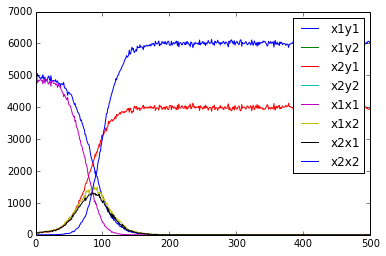

In [67]:
import numpy, random

no_gen = 500
N = 10000
x_skew = 0.1
y_skew = 0
skew_with_both_y = 1
skew_with_both_x = 1

x1, x2, y1, y2 = 0.99, 0.01, 1.0, 0.0

genotype_counts = [int(round(0.5 * N * p,  0)) for p in [x1*y1, x1*y2, x2*y1, x2*y2, x1*x1, x1*x2, x2*x1, x2*x2]]
print genotype_counts, sum(genotype_counts)

dynamic_system = numpy.empty( (8, no_gen) )
dynamic_system[:,0] = genotype_counts
for i in range(1,no_gen):
    dynamic_system[:,i] = sample_next_generation3(dynamic_system[:,i-1], N, x_skew,  y_skew, skew_with_both_y, skew_with_both_x)
    
from pylab import *
plot(dynamic_system[0,], label='x1y1')
plot(dynamic_system[1,], label='x1y2')
plot(dynamic_system[2,], label='x2y1')
plot(dynamic_system[3,], label='x2y2')
plot(dynamic_system[4,], label='x1x1')
plot(dynamic_system[5,], label='x1x2')
plot(dynamic_system[6,], label='x2x1')
plot(dynamic_system[7,], label='x2x2')
legend()

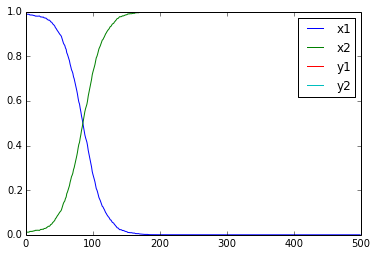

In [68]:
plot(sum(dynamic_system[x,] for x in (0, 1, 4, 4, 5, 6))/sum(dynamic_system[x,] for x in (0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7)), label='x1')
plot(sum(dynamic_system[x,] for x in (2, 3, 5, 6, 7, 7))/sum(dynamic_system[x,] for x in (0, 1, 2, 3, 4, 4, 5, 5, 6, 6, 7, 7)), label='x2')
plot(sum(dynamic_system[x,] for x in (0, 2))/sum(dynamic_system[x,] for x in (0, 1, 2, 3)), label='y1')
plot(sum(dynamic_system[x,] for x in (1, 3))/sum(dynamic_system[x,] for x in (0, 1, 2, 3)), label='y2')
legend()

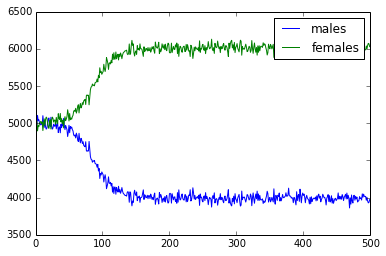

In [69]:
plot(sum(dynamic_system[x,] for x in range(4)), label='males')
plot(sum(dynamic_system[x,] for x in range(4,8)), label='females')
legend()